In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (128, 128))
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    image_list, label_list = [], []
    l = listdir(data_dir)
    for directory in l[1:5]:
        plant_image_list = listdir(f"{data_dir}/{directory}")
        for files in plant_image_list:
            image_path = f"{data_dir}/{directory}/{files}"
            image_list.append(convert_image_to_array(image_path))
            label_list.append(binary_labels[all_labels.index(directory)])
    return image_list, label_list

# Function to plot the test images
def output_plot(image, model):
    class_labels = classes
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))

    predictions = model.predict(image.reshape(1, 256, 256, 3))

    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')
    prediction_values = predictions[0]

    max_index = np.argmax(prediction_values)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])

    plt.tight_layout()
    plt.show()

In [3]:
train_dir_path = r"C:\Users\donph\Documents\dataset\tomato\tomato\train"
test_dir_path = r"C:\Users\donph\Documents\dataset\tomato\tomato\val"


all_labels = [i.split('/')[-1] for i in os.listdir(train_dir_path)]
all_labels = all_labels[1:5]
binary_labels = [int(i) for i in range(len(all_labels))]

train_images, train_labels = load_dataset(train_dir_path)
test_images, test_labels = load_dataset(test_dir_path)

In [4]:
all_labels

['Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold']

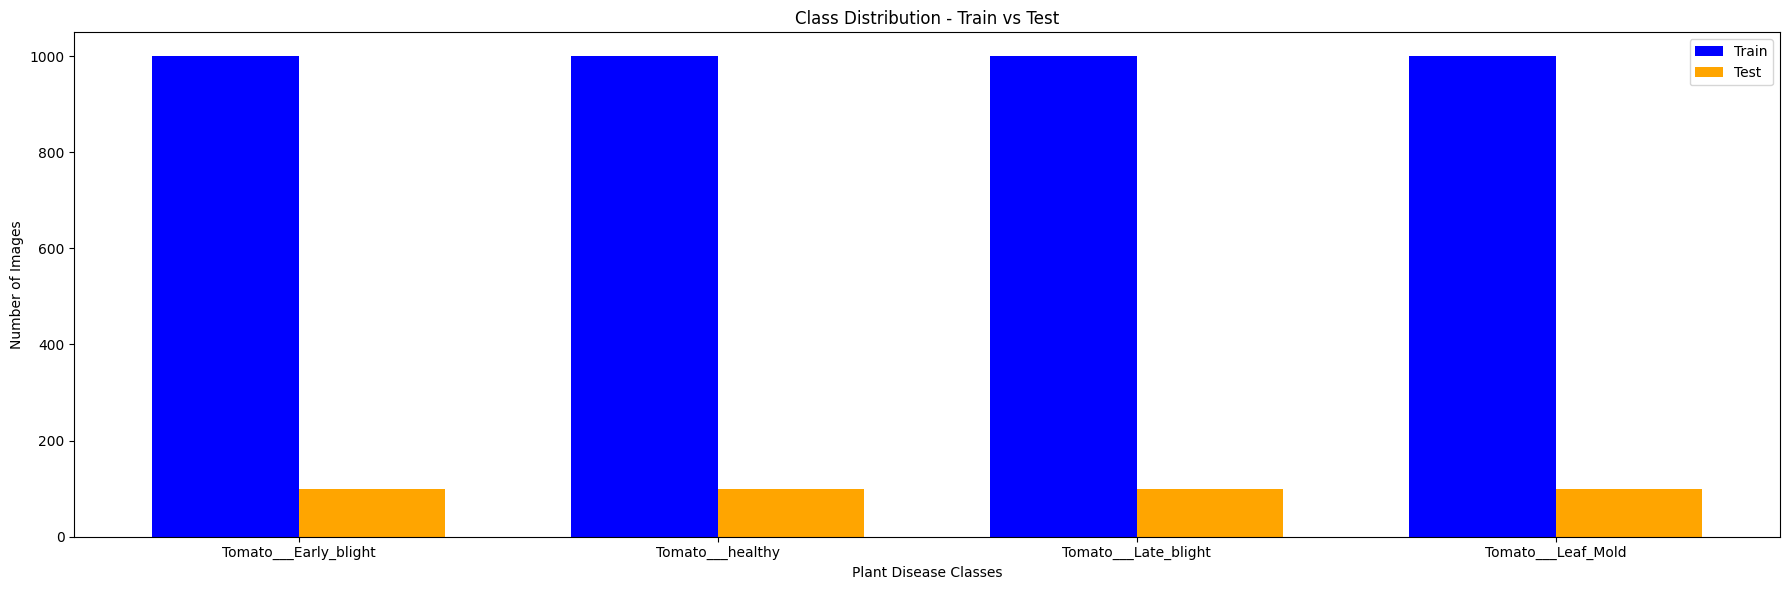

In [5]:
train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels, minlength=3)

classes = all_labels
train_colors = 'blue'
test_colors = 'orange'
bar_width = 0.35
index = np.arange(len(classes))
plt.figure(figsize=(18, 6))
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')
plt.bar(index + bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')
plt.xlabel("Plant Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution - Train vs Test")
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Normalize image data (convert pixel values to range 0-1)
x_train = np.array(train_images, dtype=np.float16) / 255.0
x_test = np.array(test_images, dtype=np.float16) / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (4000, 128, 128, 3)
x_test shape: (400, 128, 128, 3)
y_train shape: (4000, 4)
y_test shape: (400, 4)


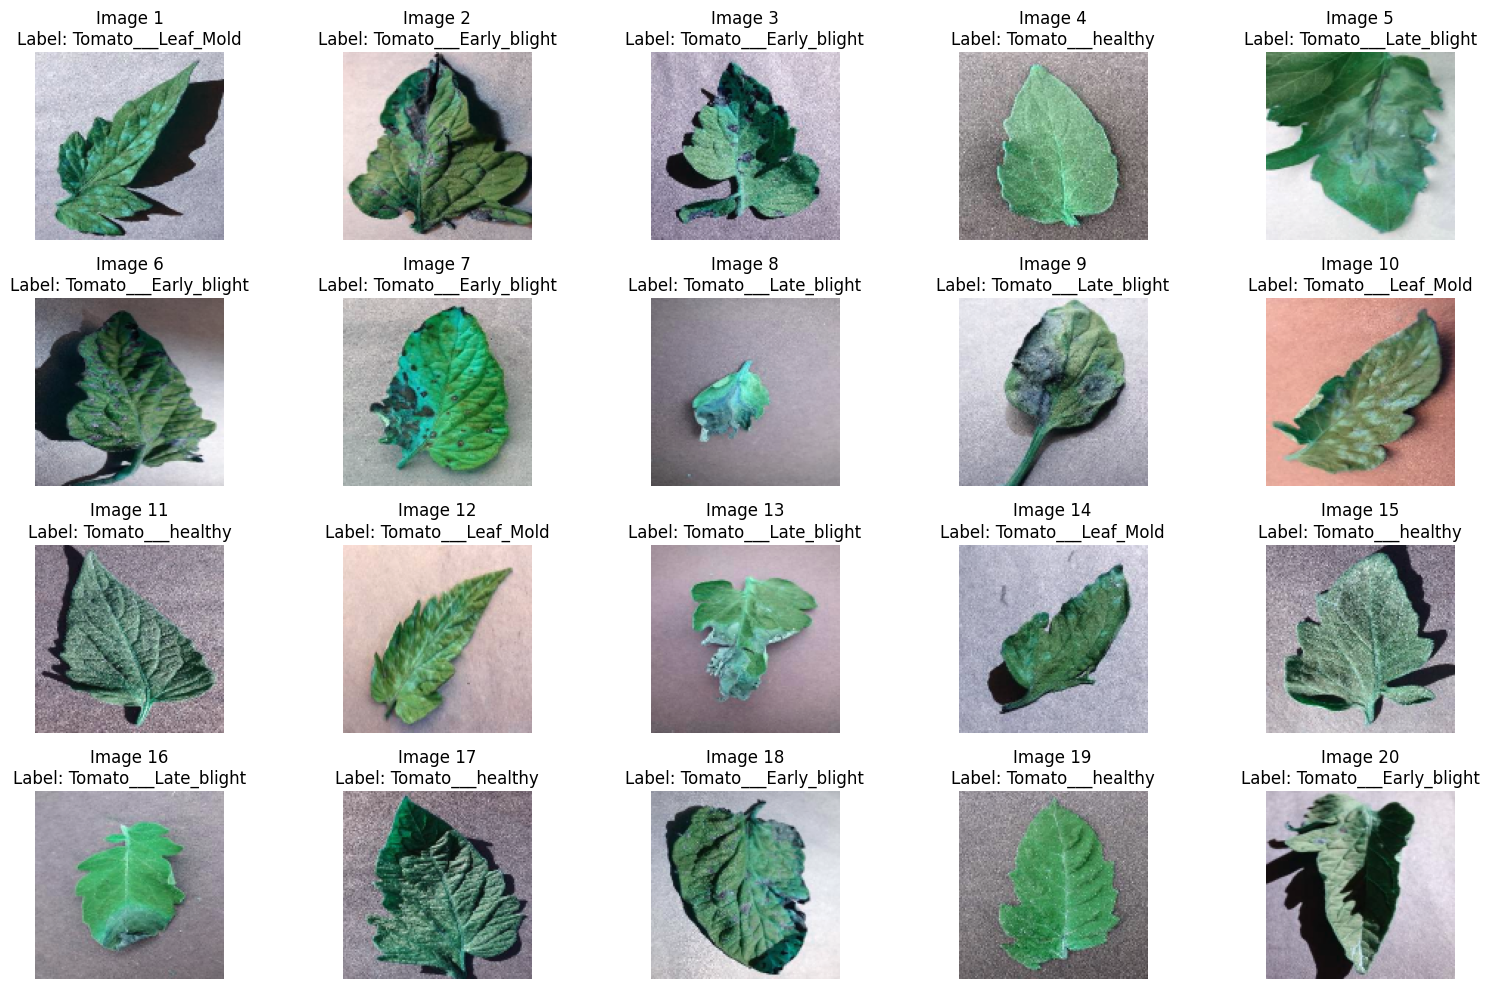

In [7]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_train)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))
    label = np.argmax(y_train[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

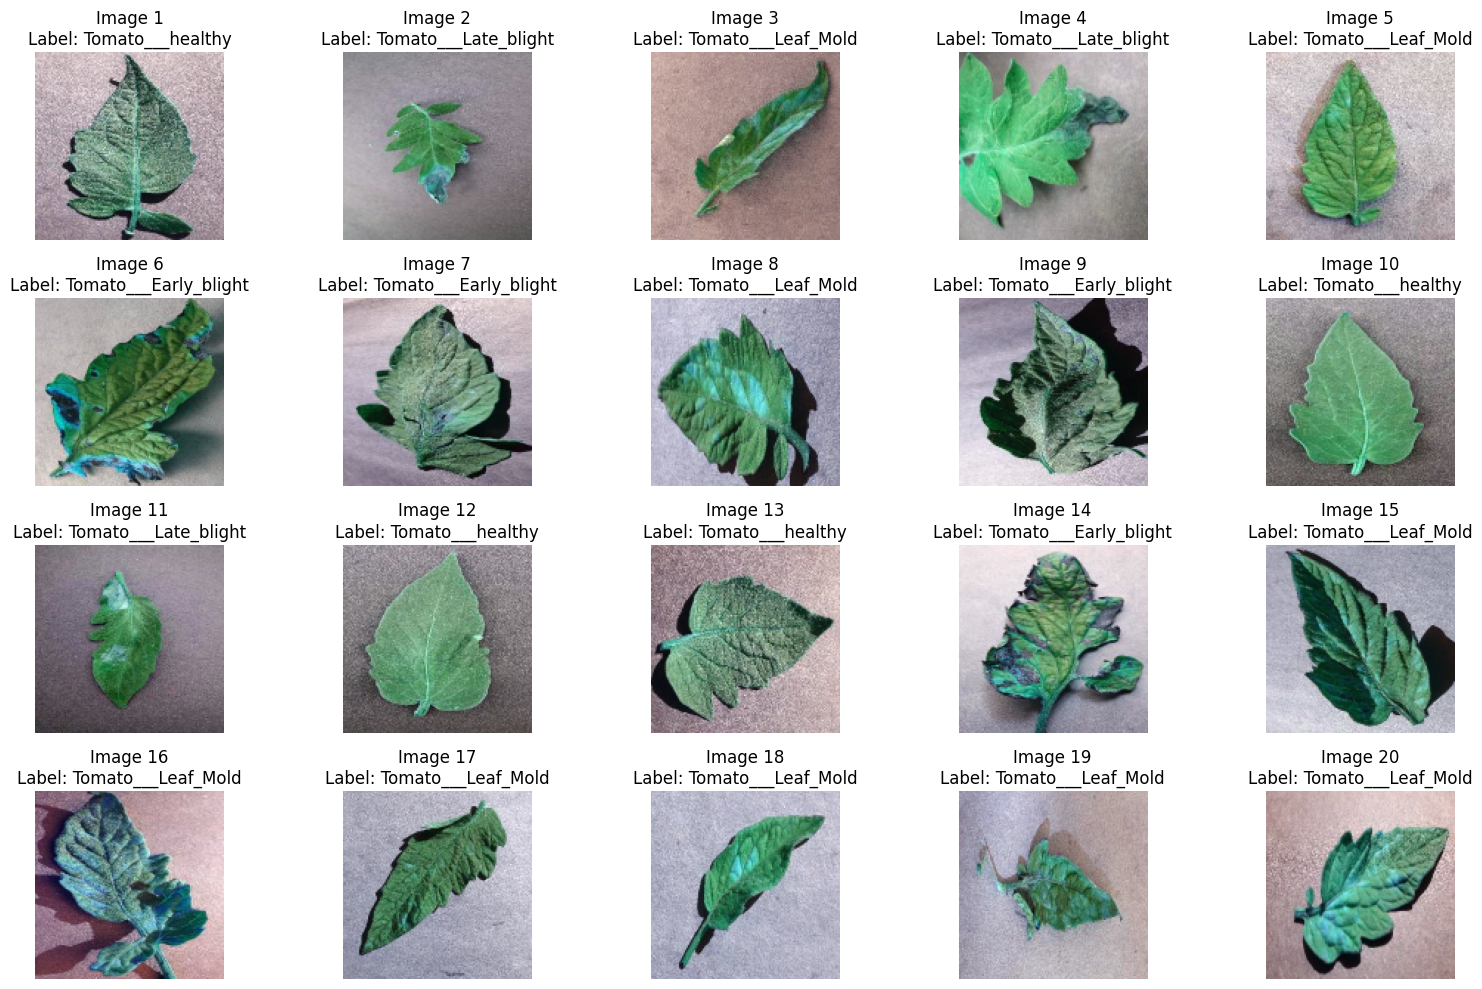

In [8]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_test)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))
    label = np.argmax(y_test[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Function to build models using popular CNN architectures
def build_model(model_name):
    if model_name == 'VGG16':
        base_model = VGG16(include_top=False, input_shape=(128, 128, 3))
    elif model_name == 'VGG19':
        base_model = VGG19(include_top=False, input_shape=(128, 128, 3))
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=(128, 128, 3))
    elif model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=False, input_shape=(128, 128, 3))

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(560, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ])

    return model

Training VGG16 model...
Epoch 1/15
200/200 [==============================] - 22s 77ms/step - loss: 1.3974 - accuracy: 0.2456 - val_loss: 1.3861 - val_accuracy: 0.2825
Epoch 2/15
200/200 [==============================] - 15s 76ms/step - loss: 1.3856 - accuracy: 0.2631 - val_loss: 1.3861 - val_accuracy: 0.2387
Epoch 3/15
200/200 [==============================] - 16s 78ms/step - loss: 1.2813 - accuracy: 0.3759 - val_loss: 1.0937 - val_accuracy: 0.5387
Epoch 4/15
200/200 [==============================] - 15s 77ms/step - loss: 0.9279 - accuracy: 0.6172 - val_loss: 0.7055 - val_accuracy: 0.6975
Epoch 5/15
200/200 [==============================] - 15s 77ms/step - loss: 0.6017 - accuracy: 0.7525 - val_loss: 0.4273 - val_accuracy: 0.8125
Epoch 6/15
200/200 [==============================] - 16s 78ms/step - loss: 0.4047 - accuracy: 0.8422 - val_loss: 0.2751 - val_accuracy: 0.8900
Epoch 7/15
200/200 [==============================] - 16s 78ms/step - loss: 0.2298 - accuracy: 0.9159 - val_loss

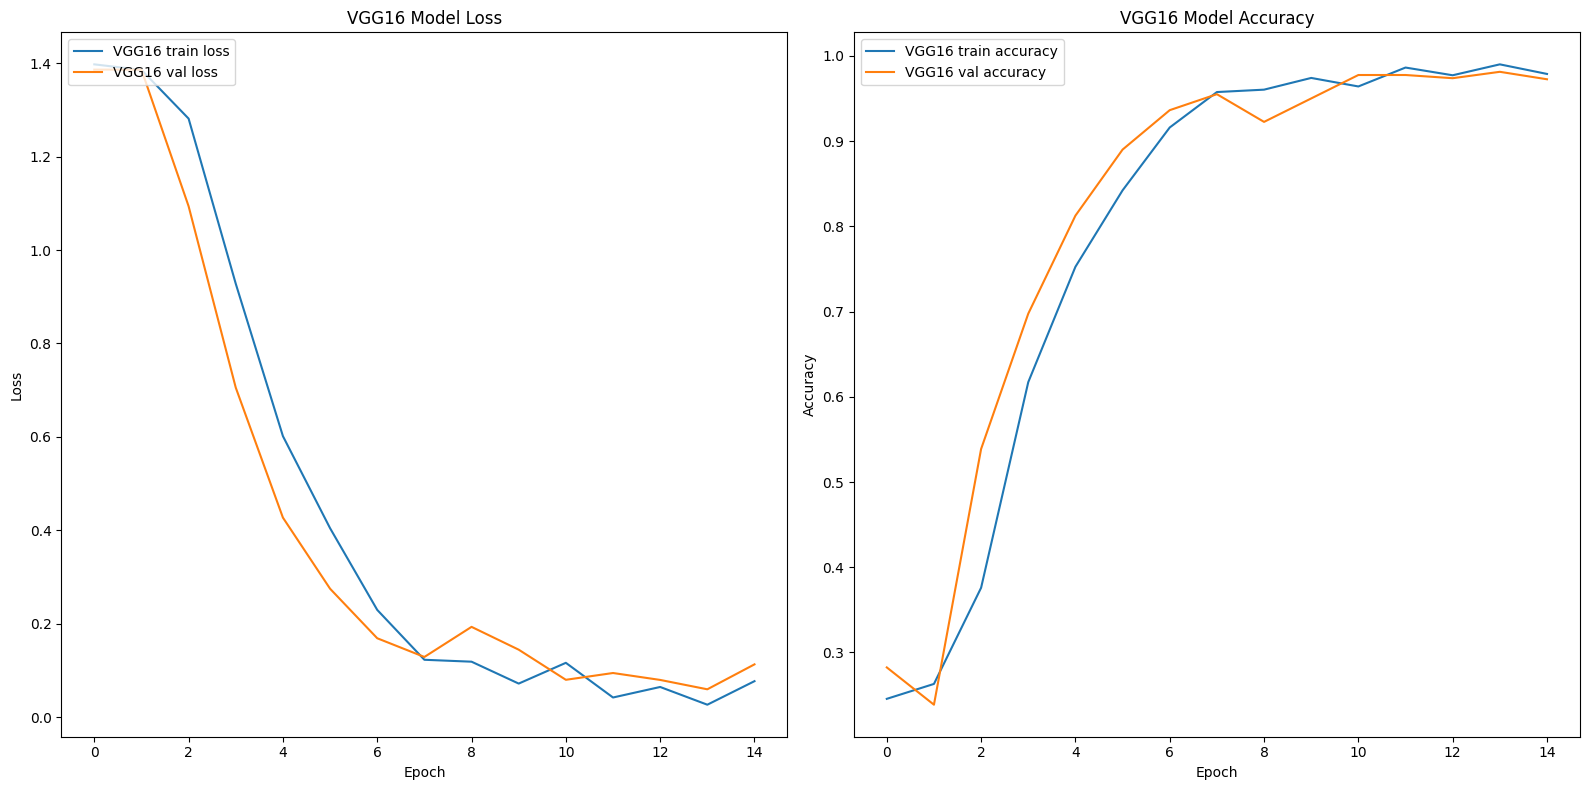

Training VGG19 model...
Epoch 1/15
200/200 [==============================] - 20s 94ms/step - loss: 1.3977 - accuracy: 0.2550 - val_loss: 1.3865 - val_accuracy: 0.2425
Epoch 2/15
200/200 [==============================] - 18s 92ms/step - loss: 1.3864 - accuracy: 0.2506 - val_loss: 1.3866 - val_accuracy: 0.2425
Epoch 3/15
200/200 [==============================] - 18s 91ms/step - loss: 1.3863 - accuracy: 0.2453 - val_loss: 1.3868 - val_accuracy: 0.2300
Epoch 4/15
200/200 [==============================] - 18s 92ms/step - loss: 1.3863 - accuracy: 0.2547 - val_loss: 1.3870 - val_accuracy: 0.2300
Epoch 5/15
200/200 [==============================] - 18s 92ms/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3869 - val_accuracy: 0.2300
Epoch 6/15
200/200 [==============================] - 18s 92ms/step - loss: 1.3864 - accuracy: 0.2491 - val_loss: 1.3872 - val_accuracy: 0.2300
Epoch 7/15
200/200 [==============================] - 18s 92ms/step - loss: 1.3863 - accuracy: 0.2531 - val_loss

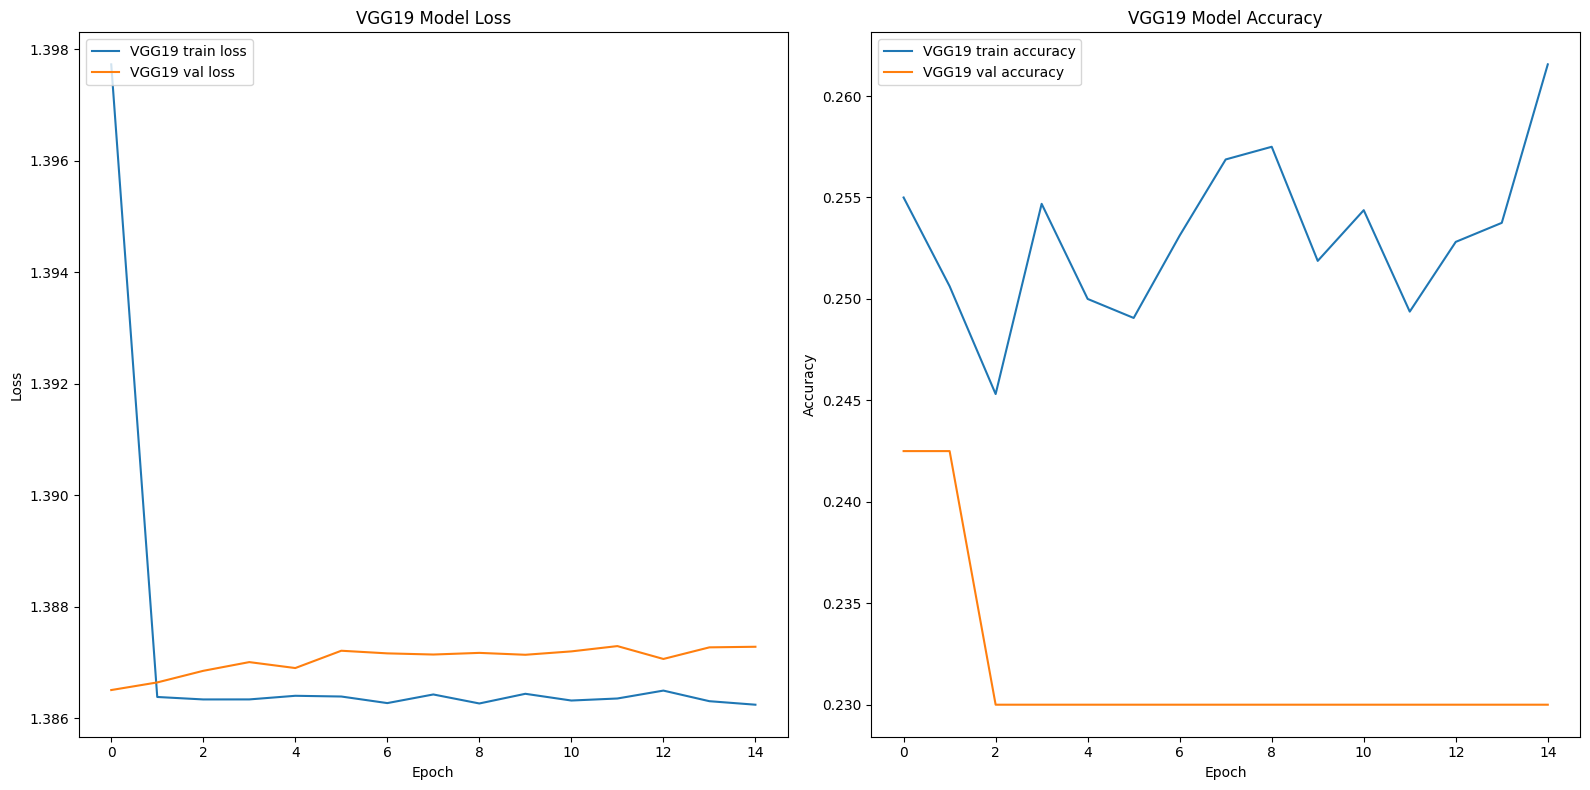

Training ResNet50 model...
Epoch 1/15
200/200 [==============================] - 18s 69ms/step - loss: 0.5062 - accuracy: 0.8072 - val_loss: 10.7226 - val_accuracy: 0.2425
Epoch 2/15
200/200 [==============================] - 13s 64ms/step - loss: 0.1427 - accuracy: 0.9522 - val_loss: 4.9328 - val_accuracy: 0.2475
Epoch 3/15
200/200 [==============================] - 13s 65ms/step - loss: 0.0771 - accuracy: 0.9747 - val_loss: 5.2743 - val_accuracy: 0.2338
Epoch 4/15
200/200 [==============================] - 13s 66ms/step - loss: 0.0639 - accuracy: 0.9819 - val_loss: 2.2708 - val_accuracy: 0.4338
Epoch 5/15
200/200 [==============================] - 13s 65ms/step - loss: 0.0634 - accuracy: 0.9847 - val_loss: 0.4524 - val_accuracy: 0.8350
Epoch 6/15
200/200 [==============================] - 13s 65ms/step - loss: 0.0460 - accuracy: 0.9872 - val_loss: 0.0898 - val_accuracy: 0.9762
Epoch 7/15
200/200 [==============================] - 13s 67ms/step - loss: 0.0345 - accuracy: 0.9903 - val_

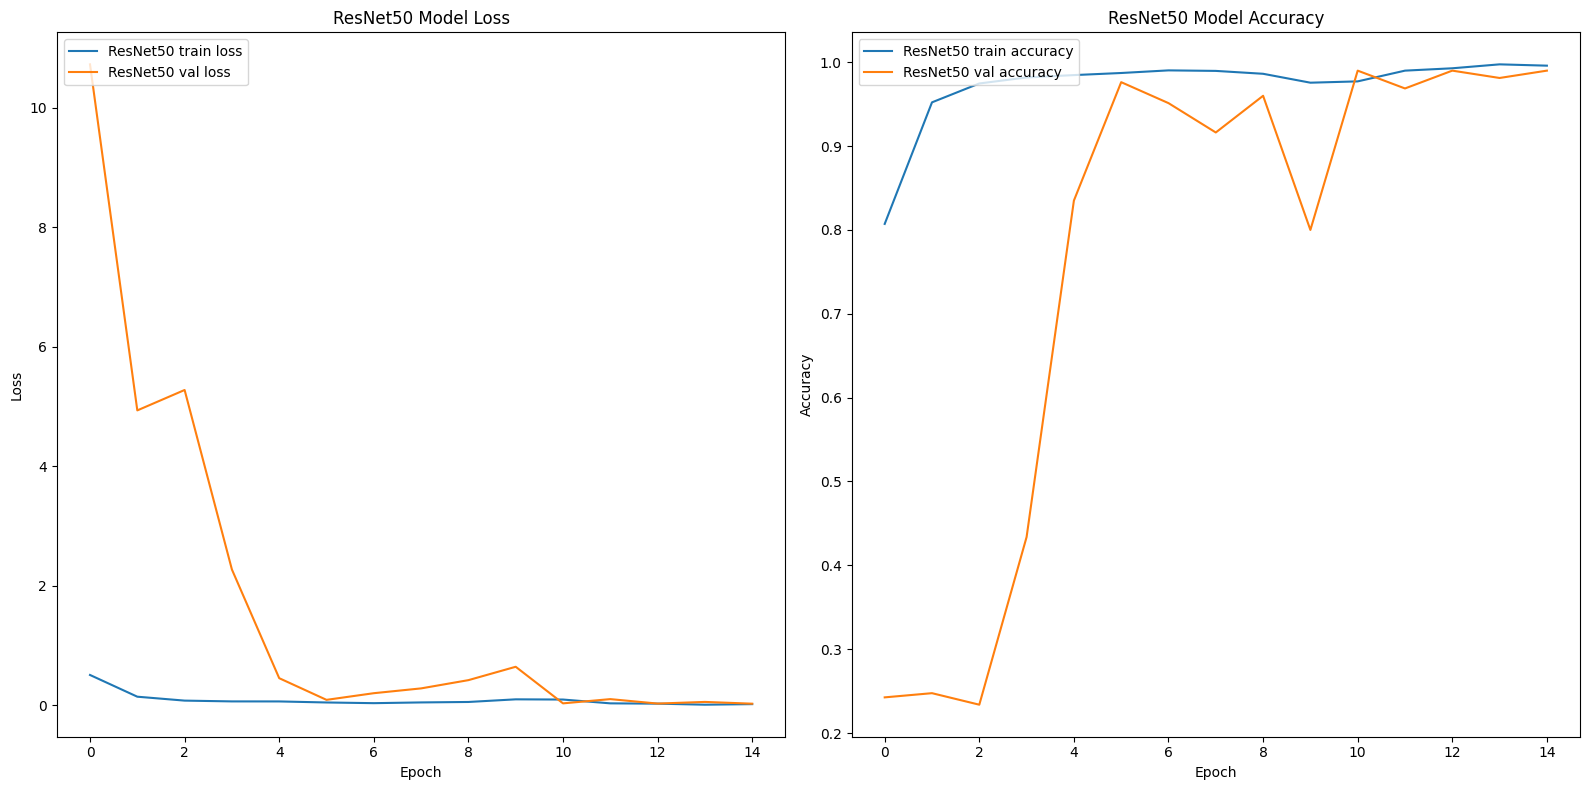

Training DenseNet121 model...
Epoch 1/15
200/200 [==============================] - 29s 108ms/step - loss: 0.6657 - accuracy: 0.7403 - val_loss: 0.3532 - val_accuracy: 0.8737
Epoch 2/15
200/200 [==============================] - 20s 102ms/step - loss: 0.1566 - accuracy: 0.9478 - val_loss: 0.0458 - val_accuracy: 0.9812
Epoch 3/15
200/200 [==============================] - 20s 99ms/step - loss: 0.0961 - accuracy: 0.9678 - val_loss: 0.0539 - val_accuracy: 0.9762
Epoch 4/15
200/200 [==============================] - 21s 105ms/step - loss: 0.0560 - accuracy: 0.9791 - val_loss: 0.0254 - val_accuracy: 0.9887
Epoch 5/15
200/200 [==============================] - 20s 101ms/step - loss: 0.0383 - accuracy: 0.9853 - val_loss: 0.0403 - val_accuracy: 0.9850
Epoch 6/15
200/200 [==============================] - 20s 101ms/step - loss: 0.0501 - accuracy: 0.9859 - val_loss: 0.0437 - val_accuracy: 0.9862
Epoch 7/15
200/200 [==============================] - 20s 102ms/step - loss: 0.0375 - accuracy: 0.986

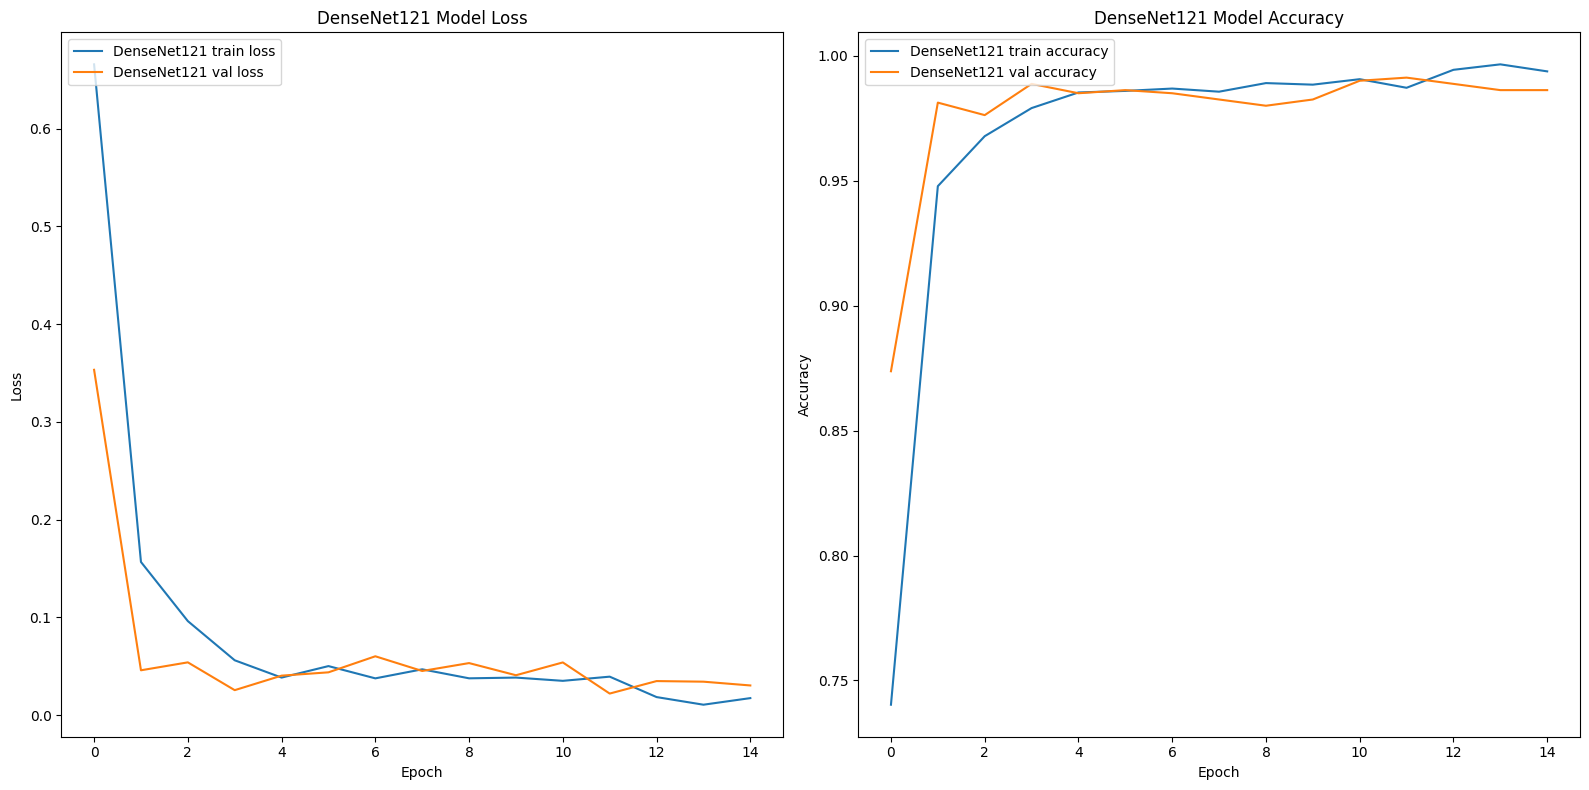

In [10]:
models = ['VGG16', 'VGG19', 'ResNet50', 'DenseNet121']
history_dict = {}
best_weights = {}

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

for model_name in models:
    print(f"Training {model_name} model...")
    model = build_model(model_name)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        batch_size=16,
        epochs=15,
        validation_data=(x_val, y_val),  # Validation data for validation split
        verbose=1
    )

    history_dict[model_name] = history.history
    best_weights[model_name] = model
    print(f"{model_name} model weights saved.")


    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    # Loss plot
    ax[0].plot(history.history['loss'], label=f'{model_name} train loss')
    ax[0].plot(history.history['val_loss'], label=f'{model_name} val loss')
    ax[0].set_title(f'{model_name} Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper left')
    # Accuracy plot
    ax[1].plot(history.history['accuracy'], label=f'{model_name} train accuracy')
    ax[1].plot(history.history['val_accuracy'], label=f'{model_name} val accuracy')
    ax[1].set_title(f'{model_name} Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [11]:
for model_name in models:
    print(f"Evaluating {model_name} model on test data...")
    model = best_weights[model_name]
    scores = model.evaluate(x_test, y_test)
    print(f"{model_name} Test Accuracy: {scores[1]*100:.2f}%")


Evaluating VGG16 model on test data...
13/13 [==============================] - 2s 33ms/step - loss: 0.1569 - accuracy: 0.9575
VGG16 Test Accuracy: 95.75%
Evaluating VGG19 model on test data...
13/13 [==============================] - 1s 38ms/step - loss: 1.3864 - accuracy: 0.2500
VGG19 Test Accuracy: 25.00%
Evaluating ResNet50 model on test data...
13/13 [==============================] - 1s 24ms/step - loss: 0.1096 - accuracy: 0.9700
ResNet50 Test Accuracy: 97.00%
Evaluating DenseNet121 model on test data...
13/13 [==============================] - 2s 33ms/step - loss: 0.0795 - accuracy: 0.9850
DenseNet121 Test Accuracy: 98.50%
